In [9]:
sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
             "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
# print(word_sequence)
word_list = " ".join(sentences).split()
print(word_list)
word_list = list(set(word_list))
print(word_list)
for i, label in enumerate(word_list):
    print(i, label)

word_dict = {w: i for i, w in enumerate(word_list)}
print(word_dict)
voc_size = len(word_list)

skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for w in context:
        skip_grams.append([target, w]) # 取上文 或者 下文，组装当前词，进行skip_grams
print(skip_grams)

['apple', 'banana', 'fruit', 'banana', 'orange', 'fruit', 'orange', 'banana', 'fruit', 'dog', 'cat', 'animal', 'cat', 'monkey', 'animal', 'monkey', 'dog', 'animal']
['animal', 'dog', 'monkey', 'fruit', 'banana', 'apple', 'cat', 'orange']
0 animal
1 dog
2 monkey
3 fruit
4 banana
5 apple
6 cat
7 orange
{'animal': 0, 'dog': 1, 'monkey': 2, 'fruit': 3, 'banana': 4, 'apple': 5, 'cat': 6, 'orange': 7}
[[4, 5], [4, 3], [3, 4], [3, 4], [4, 3], [4, 7], [7, 4], [7, 3], [3, 7], [3, 7], [7, 3], [7, 4], [4, 7], [4, 3], [3, 4], [3, 1], [1, 3], [1, 6], [6, 1], [6, 0], [0, 6], [0, 6], [6, 0], [6, 2], [2, 6], [2, 0], [0, 2], [0, 2], [2, 0], [2, 1], [1, 2], [1, 0]]


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18032\2723197381.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  input_batch = torch.Tensor(input_batch)


Epoch: 1000 cost = 2.061465
Epoch: 2000 cost = 1.768216
Epoch: 3000 cost = 1.504099
Epoch: 4000 cost = 1.253285
Epoch: 5000 cost = 0.981670


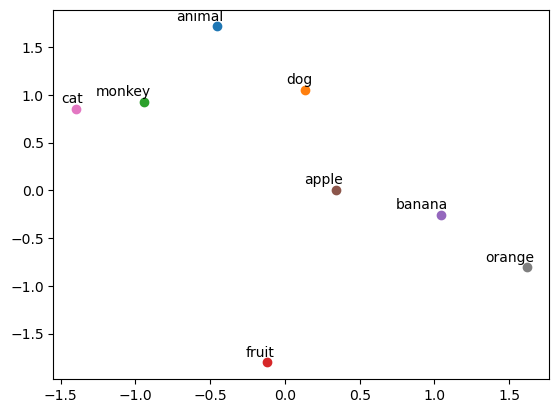

In [8]:
# code by Tae Hwan Jung @graykode
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    """
    生成随机的训练批次。

    该函数通过随机选择skip_grams中的索引来创建一个批次的数据。
    它返回一个批次的输入和标签，用于训练模型。

    Returns:
        random_inputs: 一个包含随机选择的输入词的one-hot表示的列表。
        random_labels: 一个包含随机选择的上下文词或标签的列表。
    """
    # 初始化随机输入和标签列表
    random_inputs = []
    random_labels = []
    # 随机选择batch_size个索引，这些索引用于从skip_grams中选取数据
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    # 遍历随机选择的索引
    for i in random_index:
        # 将skip_grams中的目标词转换为one-hot表示，并添加到输入列表
        # np.eye 是 NumPy 库中的一个函数，用于生成一个N维的方阵，对角线上的元素为1，其他位置的元素为0
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])
        # 将skip_grams中的上下文词添加到标签列表
        random_labels.append(skip_grams[i][1]) #第二维，是上下文，放到label

    return random_inputs, random_labels

# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

if __name__ == '__main__':
    batch_size = 2 # mini-batch size
    embedding_size = 2 # embedding size

    sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
                 "dog cat animal", "cat monkey animal", "monkey dog animal"]

    word_sequence = " ".join(sentences).split()
    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    voc_size = len(word_list)

    # Make skip gram of one size window
    skip_grams = []
    for i in range(1, len(word_sequence) - 1):
        target = word_dict[word_sequence[i]]
        context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
        for w in context:
            skip_grams.append([target, w])

    model = Word2Vec()

    #默认带softmax
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training
    for epoch in range(5000):
        input_batch, target_batch = random_batch()
        input_batch = torch.Tensor(input_batch)
        target_batch = torch.LongTensor(target_batch)

        optimizer.zero_grad()
        output = model(input_batch)

        # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
        loss = criterion(output, target_batch)
        if (epoch + 1) % 1000 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # inferenering
    for i, label in enumerate(word_list):
        W, WT = model.parameters()
        x, y = W[0][i].item(), W[1][i].item()
        plt.scatter(x, y)
        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    plt.show()